In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pandas.plotting import autocorrelation_plot

In [3]:
from statsmodels.tsa.arima.model import ARIMA

In [4]:
keras = tf.keras

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00580/hungary_chickenpox.zip"
# download and unzip required file
import requests, zipfile, io
r = requests.get(URL)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content/chickenpox")

# read the files
train_df = pd.read_csv('/content/chickenpox/hungary_chickenpox.csv')
test_df = pd.read_csv('/content/chickenpox/hungary_county_edges.csv')

In [5]:

univ_data = pd.DataFrame()
univ_data['Date'] = train_df['Date']
univ_data['TOTAL'] = train_df.iloc[:,1:].sum(axis=1)

In [6]:
univ_data.head()

,Date,TOTAL
0,03/01/2005,1807
1,10/01/2005,1407
2,17/01/2005,1284
3,24/01/2005,1255
4,31/01/2005,1478


# Helper Functions

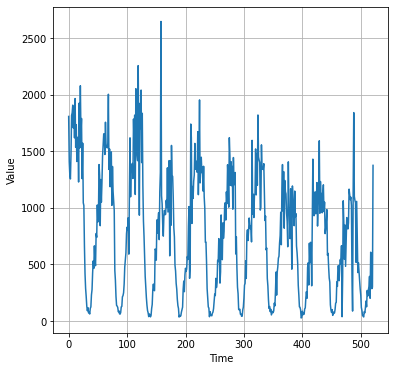

In [8]:
time = np.arange(0,522) 
series = univ_data['TOTAL']
plt.figure(figsize=(6,6))
plot_series(time,series)
plt.show()

* Series is stationary


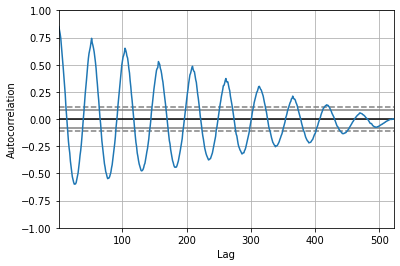

In [9]:
s = pd.Series(series,index = time)
autocorrelation_plot(s)
plt.show()


this is a positive correlation
* very close to the typical ACF of the fundamental seasonal cycle 
* AR coeff : 5

# Code

In [10]:
model = ARIMA(series, order=(5,0,0))
model_fit = model.fit()
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:                  TOTAL   No. Observations:                  522
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -3644.458
Date:                Sat, 01 May 2021   AIC                           7302.916
Time:                        14:50:43   BIC                           7332.719
Sample:                             0   HQIC                          7314.589
                                - 522                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        776.8565    167.105      4.649      0.000     449.338    1104.375
ar.L1          0.5095      0.030     17.122      0.000       0.451       0.568
ar.L2          0.2768      0.035      7.977      0.0

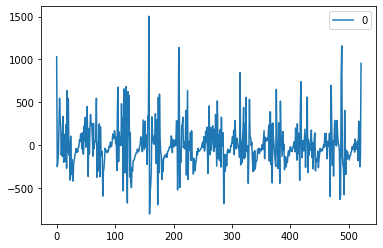

In [11]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

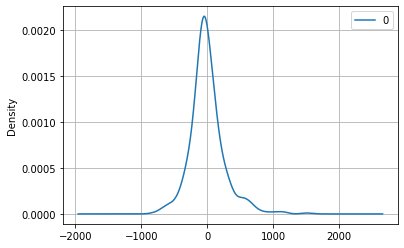

In [12]:
residuals.plot(kind='kde')
plt.grid(True)
plt.show()

In [13]:
print(residuals.describe())


                 0
count   522.000000
mean      0.010350
std     263.418998
min    -802.542089
25%    -134.055326
50%     -29.100398
75%     101.853611
max    1503.923764


Since we have a non-zero mean in residuals , hence there is bias ( slightly in this case ) in prediction

# Applying train test split and then model


In [14]:
X = series.values
train = X[0:445]
test = X[445:522]

In [15]:
history = [x for x in train]
predictions = []

In [16]:
for i in range(len(test)):
	model = ARIMA(history, order=(5,0,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	predictions.append(output[0])
	obs = test[i]
   # history is updated after each iteration since past values are important to us
	history.append(obs)

In [17]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 293.125


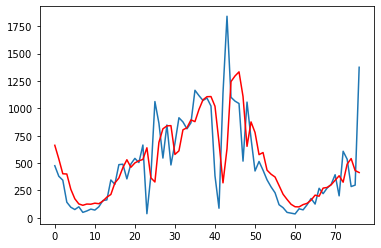

In [18]:
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

##### Arima model has not been able to make good predictions. Even worse than naive forecasting.
##### This is because of outliers present in the data since they lie outside the general trend. 
